# ERPs Analysis of averaged ERP at P1 and N1
In this notebook, we take the MATLAB files containing each subject's trials ERPs average per category. We analyse it to find the differences in hiher and lower peak latency across categories after stimulus onset.

## 1. Load data

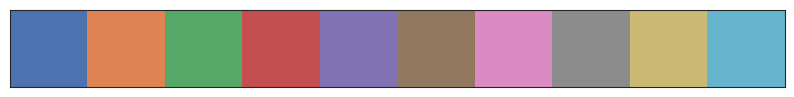

In [883]:
from os.path import dirname, join as pjoin
import scipy.io as sio
import copy
from operator import itemgetter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import argrelextrema
from io import StringIO
import pandas as pd
import pyxdf
import dataframe_image as dfi
import seaborn as sns
sns.set_style("white")
# choosing the color palette
deep_pal = sns.color_palette('deep')
sns.palplot(deep_pal)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
data_path  = "data/erps"
erps_file = pjoin(data_path, "mean_activation_all_8_sub_PO8.mat")
erps_content = sio.loadmat(erps_file)
erps_content

In [4]:
orginal_keys_map = {'body': 'erps_body', 'face': 'erps_face', 'object': 'erps_object', 'subj_time': 'subj_time'}
ch_keys = ["body", "face", "object"]
all_keys = ch_keys.copy()
all_keys.append("subj_time")
df = pd.DataFrame(columns=np.concatenate([all_keys]))

# Extract data for each participant, as many as there are time series
participant_count = len(dict(erps_content)["subj_time"])
for participant in range(participant_count):
    df_participant = pd.DataFrame()
    # Extract all keys into dataframe columns
    for key in all_keys:
        series_array = dict(erps_content)[orginal_keys_map[key]]
        df_participant[key] = pd.Series(series_array[participant])
    df_participant['subject'] = participant

    # Add full participant extraction to final dataframe
    df = pd.concat([df, df_participant], ignore_index=True)

df

body      face    object   subj_time  subject
0     5.915901  6.110841  5.858163 -199.218750      0.0
1     6.088581  6.456994  6.140627 -197.265625      0.0
2     6.139641  6.606117  6.448425 -195.312500      0.0
3     6.593696  6.790761  6.460158 -193.359375      0.0
4     6.589998  7.117500  6.645327 -191.406250      0.0
...        ...       ...       ...         ...      ...
2859  5.010485  5.210922  4.485417  490.234375      7.0
2860  5.001881  5.355083  4.451282  492.187500      7.0
2861  5.043113  5.256223  4.632553  494.140625      7.0
2862  5.057186  5.056796  4.908361  496.093750      7.0
2863  4.741613  5.175090  4.924191  498.046875      7.0

[2864 rows x 5 columns]

## 2. Long format data

In [5]:
# by melting the df this way, I can easily plot the 'variable' columns that contains all categories
df2 = df.melt(id_vars=["subj_time","subject"])
df2

subj_time  subject variable     value
0    -199.218750      0.0     body  5.915901
1    -197.265625      0.0     body  6.088581
2    -195.312500      0.0     body  6.139641
3    -193.359375      0.0     body  6.593696
4    -191.406250      0.0     body  6.589998
...          ...      ...      ...       ...
8587  490.234375      7.0   object  4.485417
8588  492.187500      7.0   object  4.451282
8589  494.140625      7.0   object  4.632553
8590  496.093750      7.0   object  4.908361
8591  498.046875      7.0   object  4.924191

[8592 rows x 4 columns]

### 2.1 Visualize given data
We can see that given ERP signal average out with no clear wave form. We need to correct the times so that peaks are at about the same time.

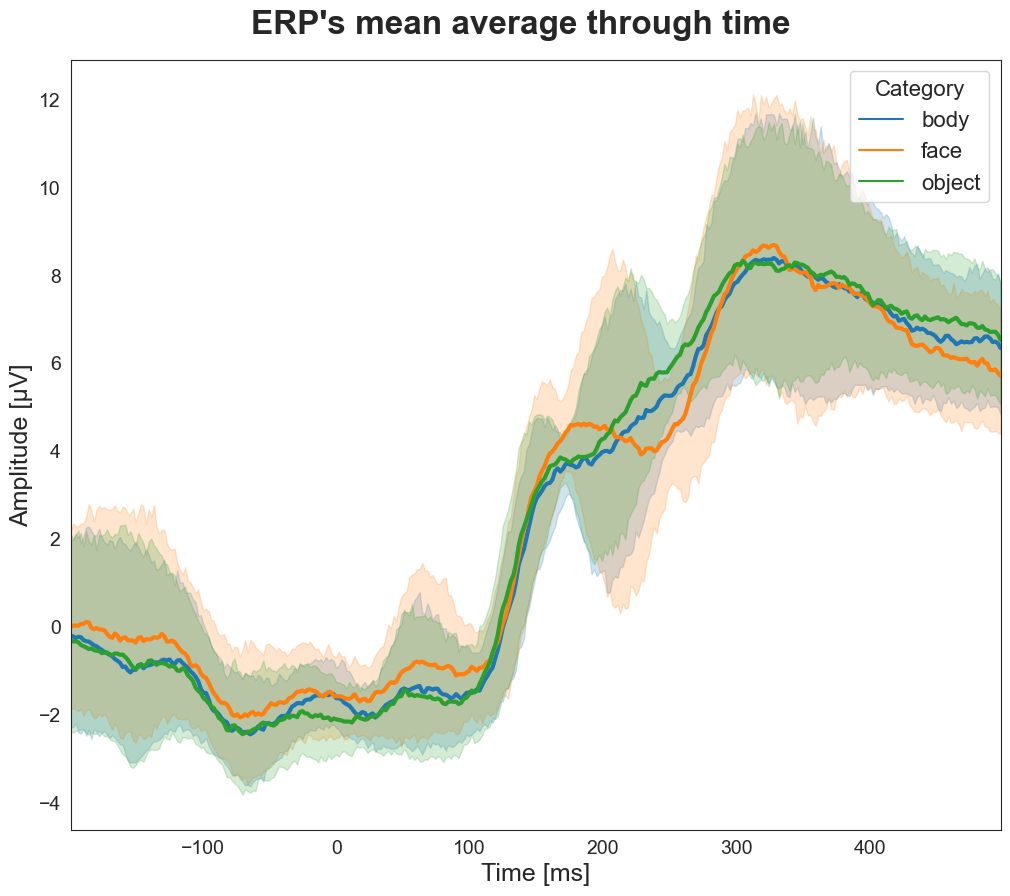

In [980]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 10))
plt.rcParams.update({'font.size': 14})
fig.suptitle("ERP's mean average through time",fontsize=24, y=0.93, fontweight='bold')
sns.lineplot(data= df2, x='subj_time', y='value', hue='variable', linewidth=3, ax=ax)
ax.set_ylabel("Amplitude [\u03BCV]", fontsize=18)
ax.set_xlabel("Time [ms]", fontsize=18)
plt.legend(title='Category',fontsize=16, title_fontsize='16')
ax.set_xlim(df2['subj_time'].min(),df2['subj_time'].max())
plt.show()

## 3. Create time windows to calculate maximum peak and minimum wave deflection

In [7]:
n = 10  # number of points to be checked before and after
rolling_gradient_window = 20
find_gradient_extrema_start_time = 0 # start to look for gradient extrema
find_gradient_extrema_end_time = 200

# Clean up old dataframe before making a copy
if 'df3' in locals():
    del df3
df3 = df

# Calculate local maxima and minima
for key in ch_keys:
    df3[key+'_min'] = df3.iloc[argrelextrema(df3[key].values, np.less_equal, order=n)[0]][key]
    df3[key+'_max'] = df3.iloc[argrelextrema(df3[key].values, np.greater_equal, order=n)[0]][key]

    # Calculate gradients, i.e., slops of the data; hypothesis: first steepest upwards gradient is where the time window for the max / min should be looked for
    df3[key+'_grads'] = np.gradient(df3[key].rolling(rolling_gradient_window, center=True).mean())
    grads_extrema = []

    # Find extrema (min max) per participant
    for participant in range(participant_count):
        df3_part = df3[(df3['subject'] == participant) & # select participant
                       (df3['subj_time'] > find_gradient_extrema_start_time) & # select start time to find gradient extrema
                       (df3['subj_time'] <= find_gradient_extrema_end_time)] # select end time to find graident extrema
        # grads_extrema.append(df3_part[key+"_grads"].idxmin())
        grads_extrema.append(df3_part[key+"_grads"].idxmax())

    # Store all gradient extrema back into the pandas dataframe
    df3[key+'_grads_extrema'] = df3.iloc[np.array(grads_extrema)][key+"_grads"]
    df3[key+'_grads_extrema_key_value'] = df3.loc[df3[key+'_grads_extrema'].notna()][key]

df3

body      face    object   subj_time  subject  body_min  body_max  \
0     5.915901  6.110841  5.858163 -199.218750      0.0  5.915901       NaN   
1     6.088581  6.456994  6.140627 -197.265625      0.0       NaN       NaN   
2     6.139641  6.606117  6.448425 -195.312500      0.0       NaN       NaN   
3     6.593696  6.790761  6.460158 -193.359375      0.0       NaN       NaN   
4     6.589998  7.117500  6.645327 -191.406250      0.0       NaN       NaN   
...        ...       ...       ...         ...      ...       ...       ...   
2859  5.010485  5.210922  4.485417  490.234375      7.0       NaN       NaN   
2860  5.001881  5.355083  4.451282  492.187500      7.0       NaN       NaN   
2861  5.043113  5.256223  4.632553  494.140625      7.0       NaN       NaN   
2862  5.057186  5.056796  4.908361  496.093750      7.0       NaN       NaN   
2863  4.741613  5.175090  4.924191  498.046875      7.0  4.741613       NaN   

      body_grads  body_grads_extrema  body_grads_extrema_key_value  face_min  \
0            NaN                 NaN                           NaN  6.110841   
1            NaN                 NaN                           NaN       NaN   
2            NaN                 NaN                           NaN       NaN   
3            NaN                 NaN                           NaN       NaN   
4            NaN                 NaN                           NaN       NaN   
...          ...                 ...                           ...       ...   
2859         NaN                 NaN                           NaN       NaN   
2860         NaN                 NaN                           NaN       NaN   
2861         NaN                 NaN                           NaN       NaN   
2862         NaN                 NaN                           NaN       NaN   
2863         NaN                 NaN                           NaN       NaN   

      face_max  face_grads  face_grads_extrema  face_grads_extrema_key_value  \
0          NaN         NaN                 NaN                           NaN   
1          NaN         NaN                 NaN                           NaN   
2          NaN         NaN                 NaN                           NaN   
3          NaN         NaN                 NaN                           NaN   
4          NaN         NaN                 NaN                           NaN   
...        ...         ...                 ...                           ...   
2859       NaN         NaN                 NaN                           NaN   
2860  5.355083         NaN                 NaN                           NaN   
2861       NaN         NaN                 NaN                           NaN   
2862       NaN         NaN                 NaN                           NaN   
2863       NaN         NaN                 NaN                           NaN   

      object_min  object_max  object_grads  object_grads_extrema  \
0       5.858163         NaN           NaN                   NaN   
1            NaN         NaN           NaN                   NaN   
2            NaN         NaN           NaN                   NaN   
3            NaN         NaN           NaN                   NaN   
4            NaN         NaN           NaN                   NaN   
...          ...         ...           ...                   ...   
2859         NaN         NaN           NaN                   NaN   
2860    4.451282         NaN           NaN                   NaN   
2861         NaN         NaN           NaN                   NaN   
2862         NaN         NaN           NaN                   NaN   
2863         NaN    4.924191           NaN                   NaN   

      object_grads_extrema_key_value  
0                                NaN  
1                                NaN  
2                                NaN  
3                                NaN  
4                                NaN  
...                              ...  
2859                             NaN  
2860      

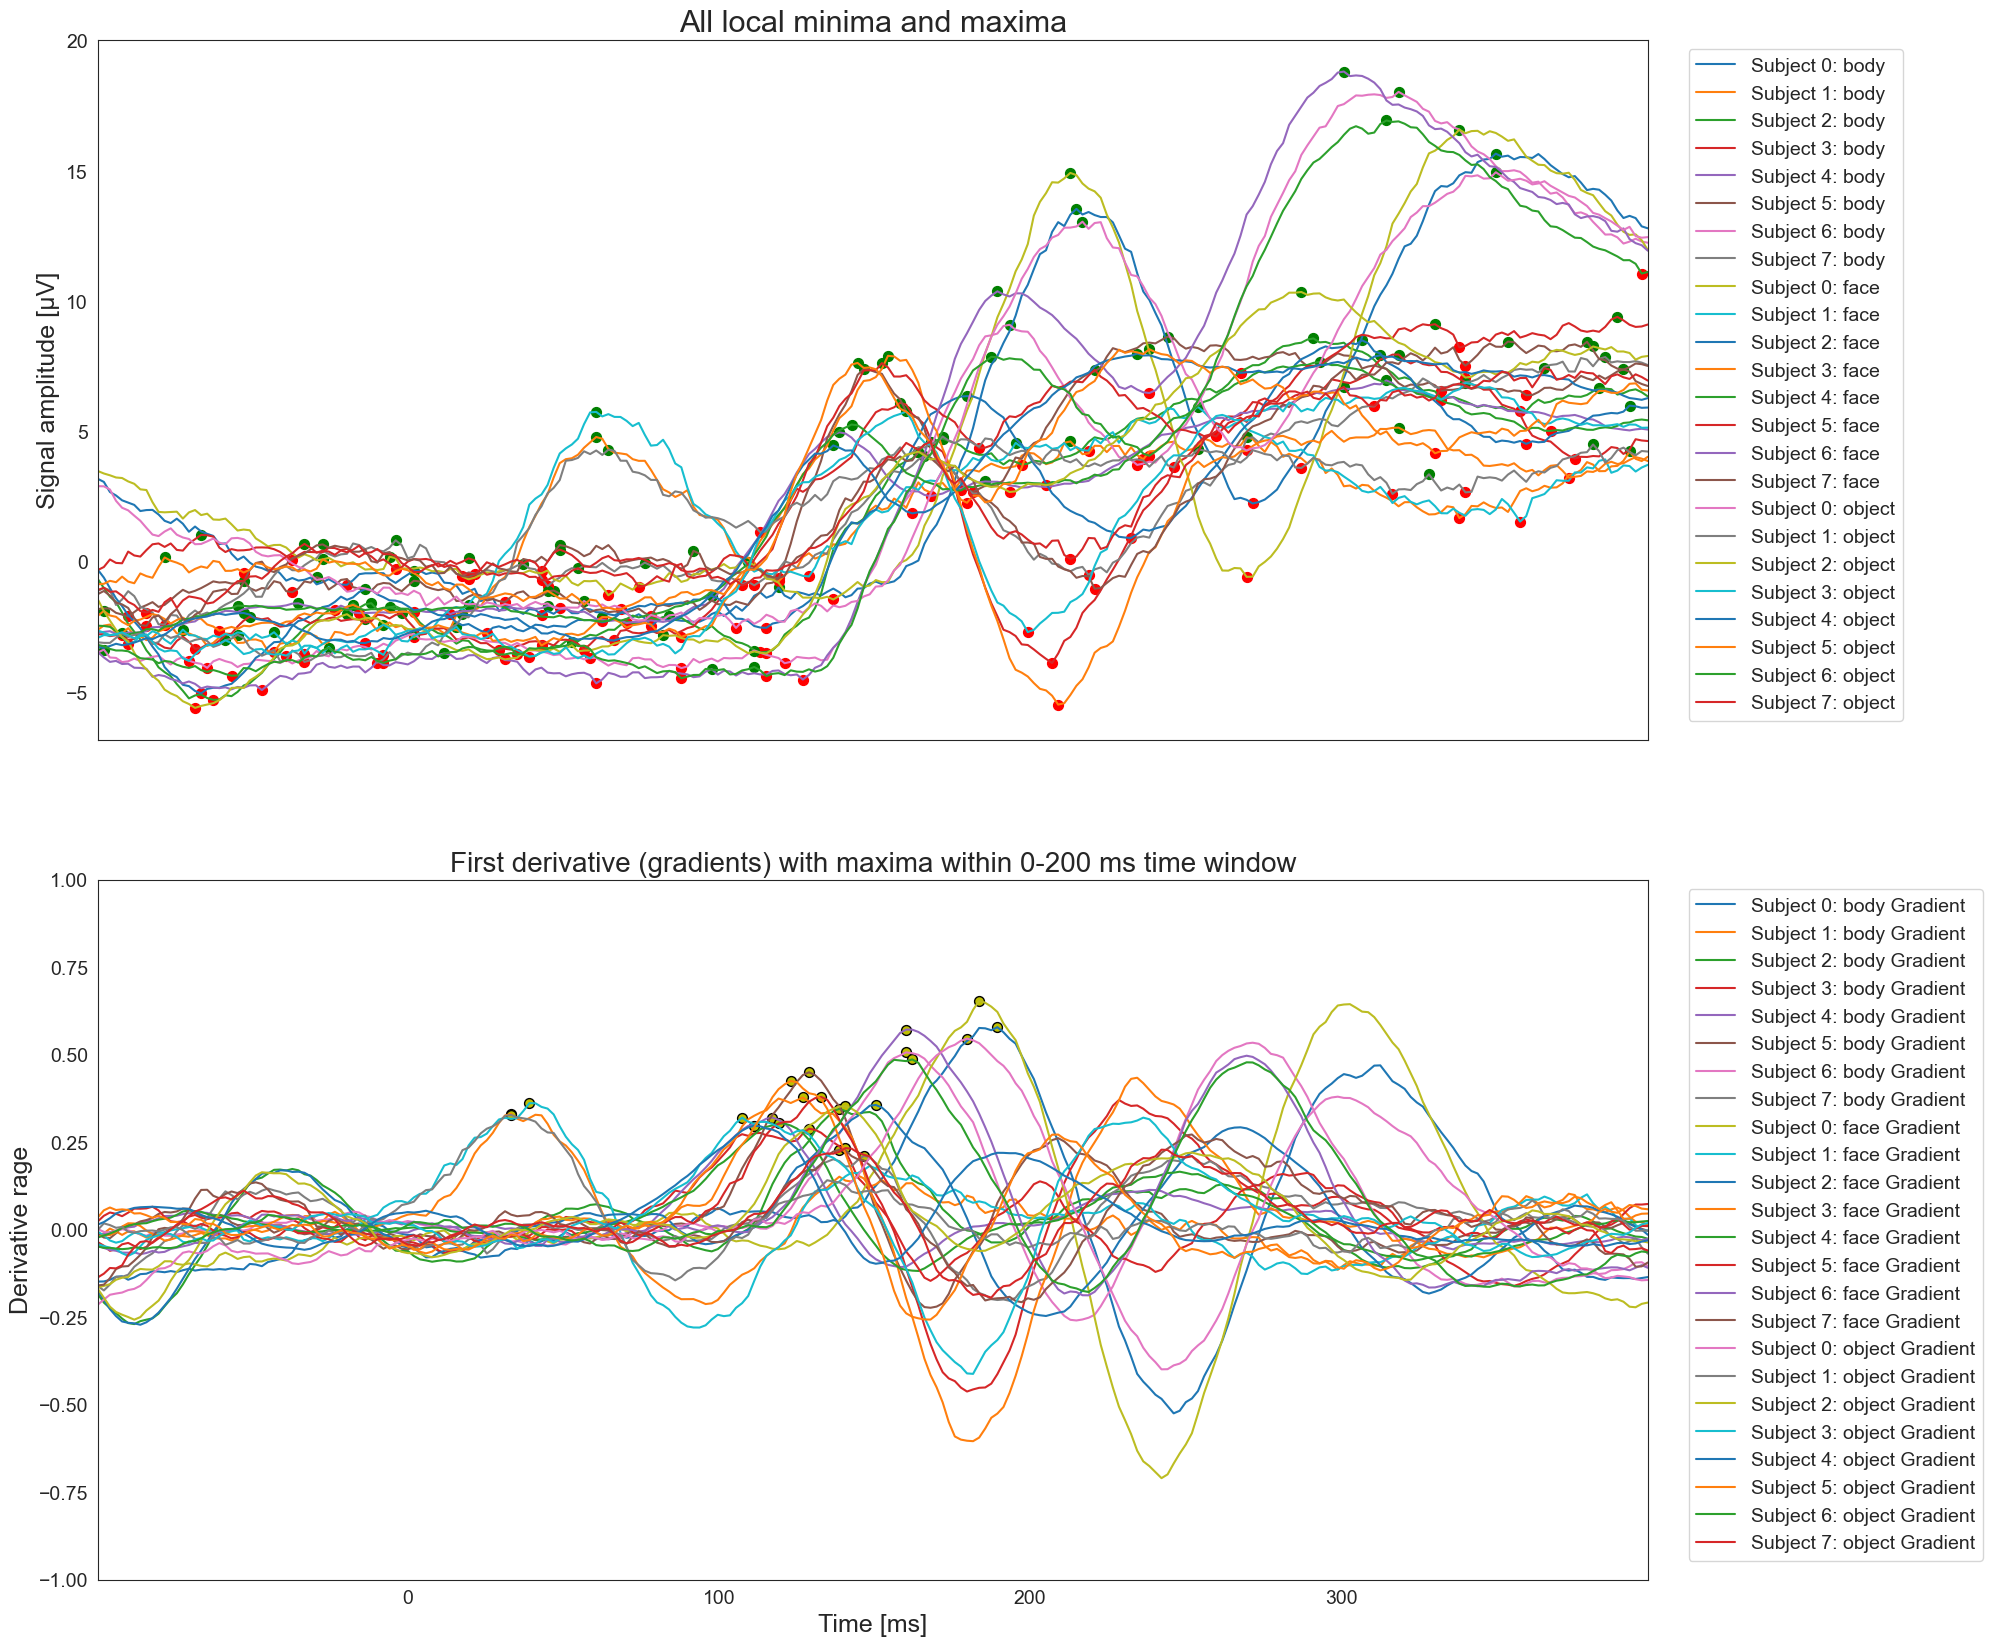

In [10]:
# Plot maximums and minimums
global_time_window_start = -100
global_time_window_end = 400

fig, ax = plt.subplots(figsize=(20,20), ncols=1, nrows=2, sharex=True)

for key in ch_keys:
    for participant in range(participant_count):
        df4 = df3[df3['subject'] == participant] # select participant
        df4 = df4[(df4['subj_time'] > global_time_window_start) & (df4['subj_time'] < global_time_window_end)] # select time window
        ax[0].scatter(df4.subj_time, df4[key+'_min'], c='r', s=50)
        ax[0].scatter(df4.subj_time, df4[key+'_max'], c='g',s=50)
        line, = ax[0].plot(df4.subj_time, df4[key])
        line.set_label(f"Subject {participant}: {key}")
        ax[0].set_title("All local minima and maxima", fontsize=22)
        ax[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        ax[0].set_xlim(df4['subj_time'].min(),df4['subj_time'].max())
        ax[0].set_ylabel("Signal amplitude [\u03BCV]", fontsize=18)

        # # Also print gradients and their extrema
        ax[1].scatter(df4.subj_time, df4[key+'_grads_extrema'], c='y',s=50,edgecolors='black')
        line, = ax[1].plot(df4.subj_time, df4[key+'_grads'])
        line.set_label(f"Subject {participant}: {key} Gradient")
        ax[1].set_xlim(df4['subj_time'].min(),df4['subj_time'].max())
        # find the point in time when slope is the steepest of smoothened data (n=20)
        ax[1].set_title("First derivative (gradients) with maxima within 0-200 ms time window", fontsize=20)
        ax[1].set_ylim(-1,1)
        ax[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        ax[1].set_ylabel("Derivative rage", fontsize=18)
        ax[1].set_xlabel("Time [ms]", fontsize=18)

plt.show()

### 3.1 Find individual peaks
Find maximum positive and negative peaks per subject

Subject 0, key body has minimum 2.2399916648864746 and maximum 13.544217109680176, difference is 11.304225444793701
Subject 0, key face has minimum -0.5760124325752258 and maximum 14.922928810119629, difference is 15.498941242694855
Subject 0, key object has minimum 4.273242473602295 and maximum 13.051939964294434, difference is 8.778697490692139


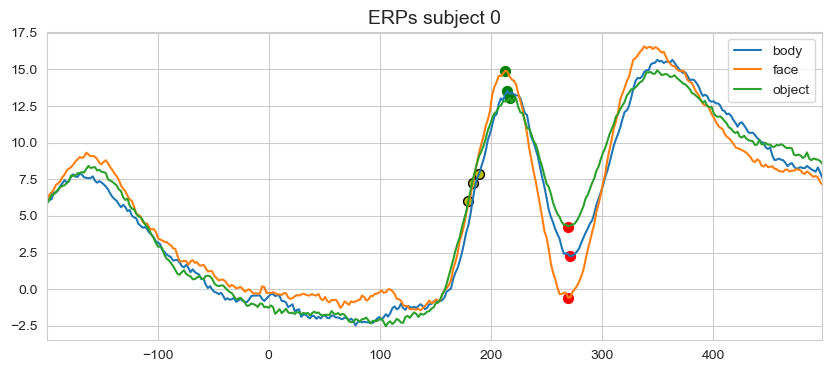

Subject 1, key body has minimum -0.7455092668533325 and maximum 4.79033088684082, difference is 5.535840153694153
Subject 1, key face has minimum -0.5618327260017395 and maximum 5.753466606140137, difference is 6.315299332141876
Subject 1, key object has minimum 1.1412217617034912 and maximum 4.3072123527526855, difference is 3.1659905910491943


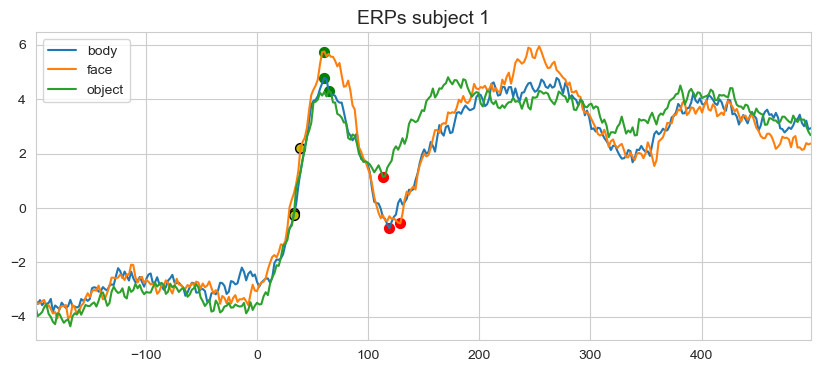

Subject 2, key body has minimum 3.7351179122924805 and maximum 4.731099605560303, difference is 0.9959816932678223
Subject 2, key face has minimum 0.9126566648483276 and maximum 6.3574323654174805, difference is 5.444775700569153
Subject 2, key object has minimum 2.679304838180542 and maximum 4.229971885681152, difference is 1.5506670475006104


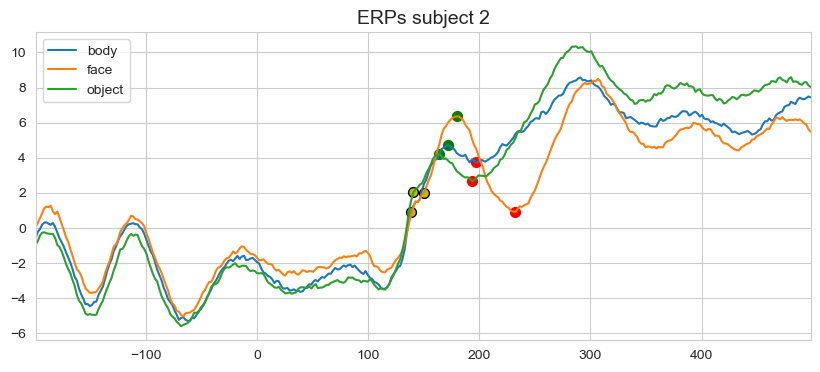

Subject 3, key body has minimum -3.881314516067505 and maximum 6.104855537414551, difference is 9.986170053482056
Subject 3, key face has minimum -5.477518558502197 and maximum 7.905889511108398, difference is 13.383408069610596
Subject 3, key object has minimum -2.695131301879883 and maximum 5.770120143890381, difference is 8.465251445770264


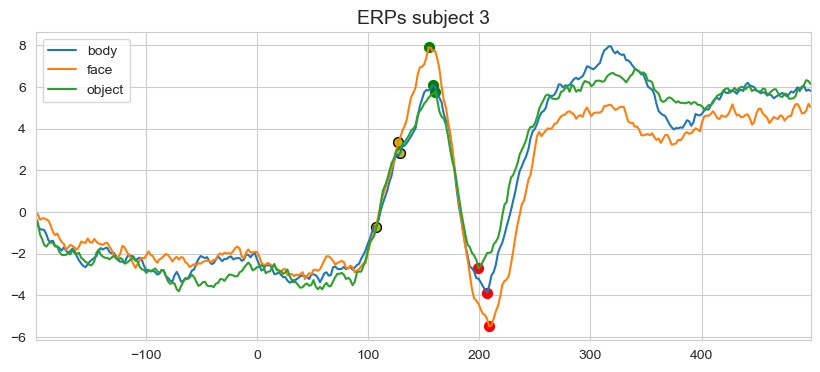

Subject 4, key body has minimum 2.5199246406555176 and maximum 4.969473838806152, difference is 2.4495491981506348
Subject 4, key face has minimum 2.738710641860962 and maximum 5.268340587615967, difference is 2.529629945755005
Subject 4, key object has minimum 1.8611074686050415 and maximum 4.465773105621338, difference is 2.6046656370162964


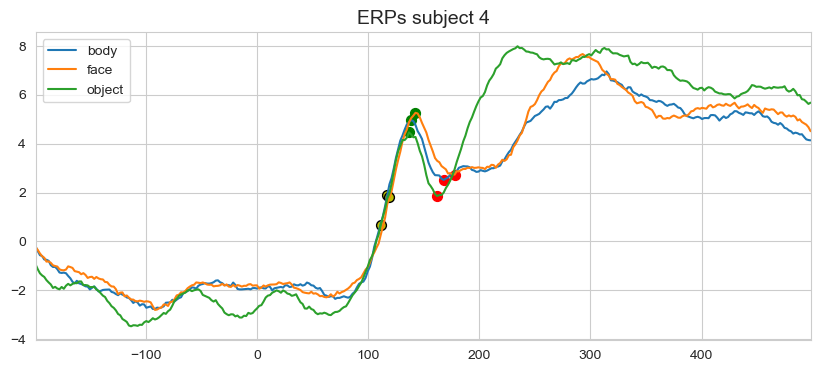

Subject 5, key body has minimum 2.687896251678467 and maximum 7.39567756652832, difference is 4.7077813148498535
Subject 5, key face has minimum 4.36458683013916 and maximum 7.625518798828125, difference is 3.260931968688965
Subject 5, key object has minimum 2.267371416091919 and maximum 7.632042407989502, difference is 5.364670991897583


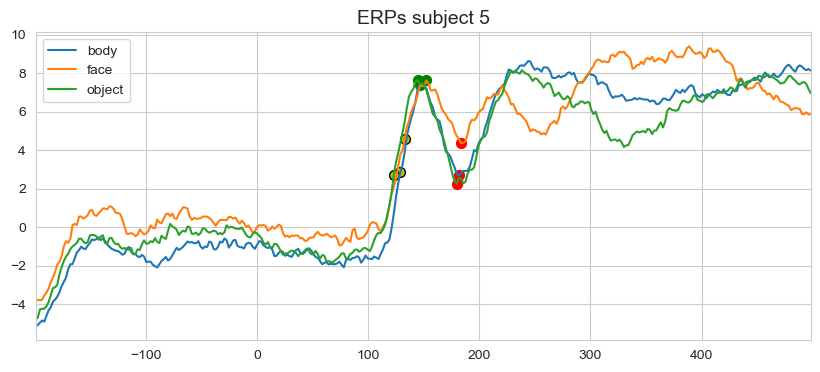

Subject 6, key body has minimum 3.719270944595337 and maximum 9.096206665039062, difference is 5.376935720443726
Subject 6, key face has minimum 6.47817325592041 and maximum 10.379767417907715, difference is 3.9015941619873047
Subject 6, key object has minimum 4.071857452392578 and maximum 7.867554187774658, difference is 3.79569673538208


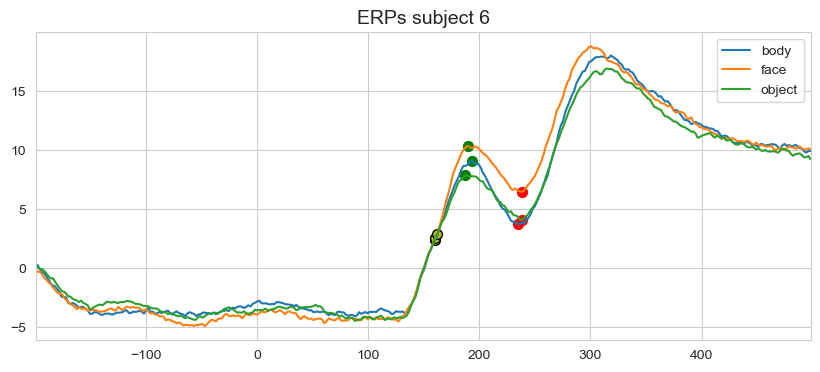

Subject 7, key body has minimum -0.5057152509689331 and maximum 4.0622687339782715, difference is 4.567983984947205
Subject 7, key face has minimum -1.0317906141281128 and maximum 4.2238006591796875, difference is 5.2555912733078
Subject 7, key object has minimum 0.11607088893651962 and maximum 4.608160495758057, difference is 4.492089606821537


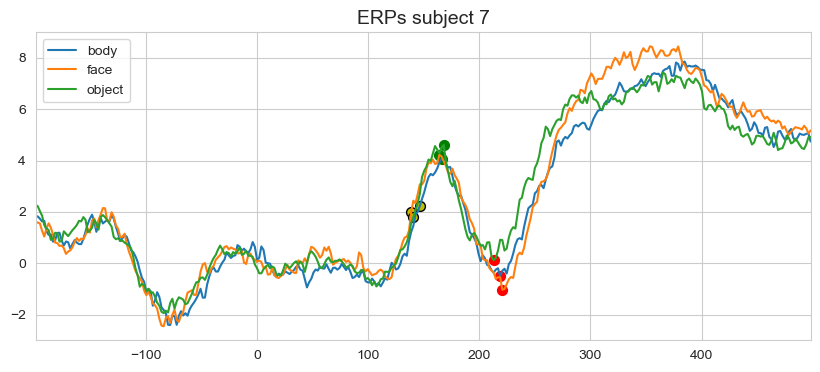

body      face    object   subj_time  subject  body_min  body_max  \
0     5.915901  6.110841  5.858163 -311.295573      0.0       NaN       NaN   
1     6.088581  6.456994  6.140627 -309.342448      0.0       NaN       NaN   
2     6.139641  6.606117  6.448425 -307.389323      0.0       NaN       NaN   
3     6.593696  6.790761  6.460158 -305.436198      0.0       NaN       NaN   
4     6.589998  7.117500  6.645327 -303.483073      0.0       NaN       NaN   
...        ...       ...       ...         ...      ...       ...       ...   
2859  5.010485  5.210922  4.485417  421.126302      7.0       NaN       NaN   
2860  5.001881  5.355083  4.451282  423.079427      7.0       NaN       NaN   
2861  5.043113  5.256223  4.632553  425.032552      7.0       NaN       NaN   
2862  5.057186  5.056796  4.908361  426.985677      7.0       NaN       NaN   
2863  4.741613  5.175090  4.924191  428.938802      7.0       NaN       NaN   

      body_grads  body_grads_extrema  body_grads_extrema_key_value  face_min  \
0            NaN                 NaN                           NaN       NaN   
1            NaN                 NaN                           NaN       NaN   
2            NaN                 NaN                           NaN       NaN   
3            NaN                 NaN                           NaN       NaN   
4            NaN                 NaN                           NaN       NaN   
...          ...                 ...                           ...       ...   
2859         NaN                 NaN                           NaN       NaN   
2860         NaN                 NaN                           NaN       NaN   
2861         NaN                 NaN                           NaN       NaN   
2862         NaN                 NaN                           NaN       NaN   
2863         NaN                 NaN                           NaN       NaN   

      face_max  face_grads  face_grads_extrema  face_grads_extrema_key_value  \
0          NaN         NaN                 NaN                           NaN   
1          NaN         NaN                 NaN                           NaN   
2          NaN         NaN                 NaN                           NaN   
3          NaN         NaN                 NaN                           NaN   
4          NaN         NaN                 NaN                           NaN   
...        ...         ...                 ...                           ...   
2859       NaN         NaN                 NaN                           NaN   
2860       NaN         NaN                 NaN                           NaN   
2861       NaN         NaN                 NaN                           NaN   
2862       NaN         NaN                 NaN                           NaN   
2863       NaN         NaN                 NaN                           NaN   

      object_min  object_max  object_grads  object_grads_extrema  \
0            NaN         NaN           NaN                   NaN   
1            NaN         NaN           NaN                   NaN   
2            NaN         NaN           NaN                   NaN   
3            NaN         NaN           NaN                   NaN   
4            NaN         NaN           NaN                   NaN   
...          ...         ...           ...                   ...   
2859         NaN         NaN           NaN                   NaN   
2860         NaN         NaN           NaN                   NaN   
2861         NaN         NaN           NaN                   NaN   
2862         NaN         NaN           NaN                   NaN   
2863         NaN         NaN           NaN                   NaN   

      object_grads_extrema_key_value  
0                                NaN  
1                                NaN  
2                                NaN  
3                                NaN  
4                                NaN  
...                              ...  
2859                             NaN  
2860      

subject     key       min        max       diff
0        0    body  2.239992  13.544217  11.304225
1        0    face -0.576012  14.922929  15.498941
2        0  object  4.273242  13.051940   8.778697
3        1    body -0.745509   4.790331   5.535840
4        1    face -0.561833   5.753467   6.315299
5        1  object  1.141222   4.307212   3.165991
6        2    body  3.735118   4.731100   0.995982
7        2    face  0.912657   6.357432   5.444776
8        2  object  2.679305   4.229972   1.550667
9        3    body -3.881315   6.104856   9.986170
10       3    face -5.477519   7.905890  13.383408
11       3  object -2.695131   5.770120   8.465251
12       4    body  2.519925   4.969474   2.449549
13       4    face  2.738711   5.268341   2.529630
14       4  object  1.861107   4.465773   2.604666
15       5    body  2.687896   7.395678   4.707781
16       5    face  4.364587   7.625519   3.260932
17       5  object  2.267371   7.632042   5.364671
18       6    body  3.719271   9.096207   5.376936
19       6    face  6.478173  10.379767   3.901594
20       6  object  4.071857   7.867554   3.795697
21       7    body -0.505715   4.062269   4.567984
22       7    face -1.031791   4.223801   5.255591
23       7  object  0.116071   4.608160   4.492090

diff
key             
body    5.615558
face    6.948771
object  4.777216

In [235]:
# Min / Max / Diff output dataframe
df_min_max = pd.DataFrame(columns=['subject', 'key', 'min', 'max', 'diff'])

# Cleaned output dataframe
if 'df_cleaned' in locals():
    del df_cleaned
df_cleaned = pd.DataFrame(columns=df3.columns)

# Dataframe to collect all signal onsets so that a time realignment at the end can be done
onset_all = pd.DataFrame()

# Store all maximum values, so we can align chart visually to have the mean maximum be at t = 100 ms
maxs_time = pd.Series(dtype='float64')

# fig, ax = plt.subplots(figsize=(20,20), ncols=2, nrows=round(participant_count/2), sharex=True)
plt.rcParams.update({'font.size': 10})
for participant in range(participant_count):
    # Set up participant visualization
    fig, ax = plt.subplots(figsize=(10,4))
    # Initiate participant cleaned dataframe
    df_participant_cleaned = df3[df3['subject'] == participant][['subject', 'subj_time']]

    ## Step 1: find the mean onset time for given participant (i.e., when gradient is steepest)
    df4 = df3[df3['subject'] == participant]
    df4.reset_index(inplace=True)

    # Get all participant's onset time stamp
    onset = pd.DataFrame()
    for key in ch_keys:
        onset = pd.concat([onset, df4.iloc[np.array([df4[key + '_grads_extrema'].idxmax()])]['subj_time']], ignore_index=True)

    onset_time_mean = onset.mean().loc[0] # use as the average subj_time time shift for this participant
    onset_time_min = onset.min().loc[0] # use as selection start time for cleaned data set and participant visualization
    onset_time_max = onset.max().loc[0] # use as selection end time for data cleaning and participant visualization (for onset points only)

    for key in ch_keys:
        ## Step 2: find the first min and max post the mean onset
        df4 = df3[(df3['subject'] == participant) &
                  (df3['subj_time'] >= onset_time_mean)]
        df4.reset_index(inplace=True)

        # Get participant first minima and maxima post the mean onset time
        max = df4.iloc[df4[key + '_max'].first_valid_index()][key + '_max']
        min = df4.iloc[df4[key + '_min'].first_valid_index()][key + '_min']

        # Store all participants maximum's time stamps
        maxs_time = pd.concat([maxs_time, pd.Series([df4.iloc[np.array([df4[key + '_max'].first_valid_index()])]['subj_time'].iloc[0]])])

        # Set the end time of the local window, so we can use this to generate a clean, aligned dataset
        local_time_window_end = df4.iloc[np.array([df4[key + '_min'].first_valid_index()])]['subj_time'].iloc[0]

        ## Step 3: Add the min + max and diff to the resulting data frame
        print(f"Subject {participant}, key {key} has minimum {min} and maximum {max}, difference is {max-min}")
        d = {'subject': [participant], 'key': [key], 'min': [min], 'max': [max], 'diff': [max-min]}
        df_min_max = pd.concat([df_min_max, pd.DataFrame.from_dict(d)], ignore_index=True)

        ## Step 4: Assemble a clean dataframe
        # Part 1: add corrected time stamp, key and key gradient data
        df4 = df3[(df3['subject'] == participant)]
        df_participant_cleaned['subj_time'] = df4['subj_time'] - onset_time_mean
        df_participant_cleaned[key] = df4[key]
        df_participant_cleaned[key + '_grads'] = df4[key + '_grads']

        # Part 2: add key's min and max data only between onset time and local time window end
        df5 = df4[(df4['subj_time'] >= onset_time_min) &
                  (df4['subj_time'] <= local_time_window_end)]
        df_participant_cleaned[key + '_min'] = df5[key + '_min']
        df_participant_cleaned[key + '_max'] = df5[key + '_max']

        # Part 3: add key's onset gradient and value at that point (select only from within onset min to max range)
        df6 = df5[df5['subj_time'] <= onset_time_max]
        df_participant_cleaned[key + '_grads_extrema'] = df6[key + '_grads_extrema']
        df_participant_cleaned[key + '_grads_extrema_key_value'] = df6[key + '_grads_extrema_key_value']

        ## Step 5: Plot each participant data
        df4_points_min_max = df4[(df4['subj_time'] >= onset_time_min) & (df4['subj_time'] <= local_time_window_end)] # select time window
        ax.scatter(df4_points_min_max.subj_time, df4_points_min_max[key+'_min'], c='r',s=50)
        ax.scatter(df4_points_min_max.subj_time, df4_points_min_max[key+'_max'], c='g',s=50)
        df4_points_onset = df4[(df4['subj_time'] >= onset_time_min) & (df4['subj_time'] <= onset_time_max)] # select time window
        ax.scatter(df4_points_onset.subj_time, df4_points_onset[key+'_grads_extrema_key_value'], c='y',s=50,edgecolors='black')
        line, = plt.plot(df4.subj_time, df4[key])
        line.set_label(f"{key}")
        ax.set_title(f"ERPs subject {participant}", fontsize=14)
        ax.set_xlim(df4['subj_time'].min(),df4['subj_time'].max())
        plt.legend()

    # Assemble cleaned data frame
    df_cleaned = pd.concat([df_cleaned, df_participant_cleaned], ignore_index=True)

    # Collect participant's onset points
    onset_all = pd.concat([onset_all, onset], ignore_index=True)

    # Visualize participant
    # plt.legend()
    plt.show()


# Method 1: Add mean onset back to regain time series alignment for cleaned data frame
#df_cleaned['subj_time'] = df_cleaned['subj_time'].add(onset_all.mean().loc[0])

# Method 2: Add mean of maximums - 100ms back to align time series for cleaned data frame such that maximums are at t = 100ms
df_cleaned['subj_time'] = df_cleaned['subj_time'].add(onset_all.mean().loc[0] - maxs_time.mean() + 100)

# Calculate start time of fully overlapping participant data
cleaned_start_time = df_cleaned.groupby(['subject']).agg({'subj_time': 'min'}).max().iloc[0]

# Align time stamps into buckets
bucket_time = df_cleaned[df_cleaned['subj_time'] >= cleaned_start_time][['subject', 'subj_time']].sort_values(by=['subj_time', 'subject']).iloc[0:participant_count].sort_values(by=['subject'])
bucket_time['subj_time'] = bucket_time['subj_time'].sub(bucket_time['subj_time'].mean())
df_cleaned['subj_time'] = df_cleaned.apply(lambda x: round(x['subj_time'] - bucket_time[bucket_time['subject'] == x['subject']]['subj_time'].min(), 6), axis = 1)

# Calculate new end time of fully overlapping participant data
cleaned_end_time = df_cleaned.groupby(['subject']).agg({'subj_time': 'max'}).min().iloc[0]

display(df_cleaned, df_min_max, df_min_max.groupby(['key']).agg({'diff': 'mean'}))

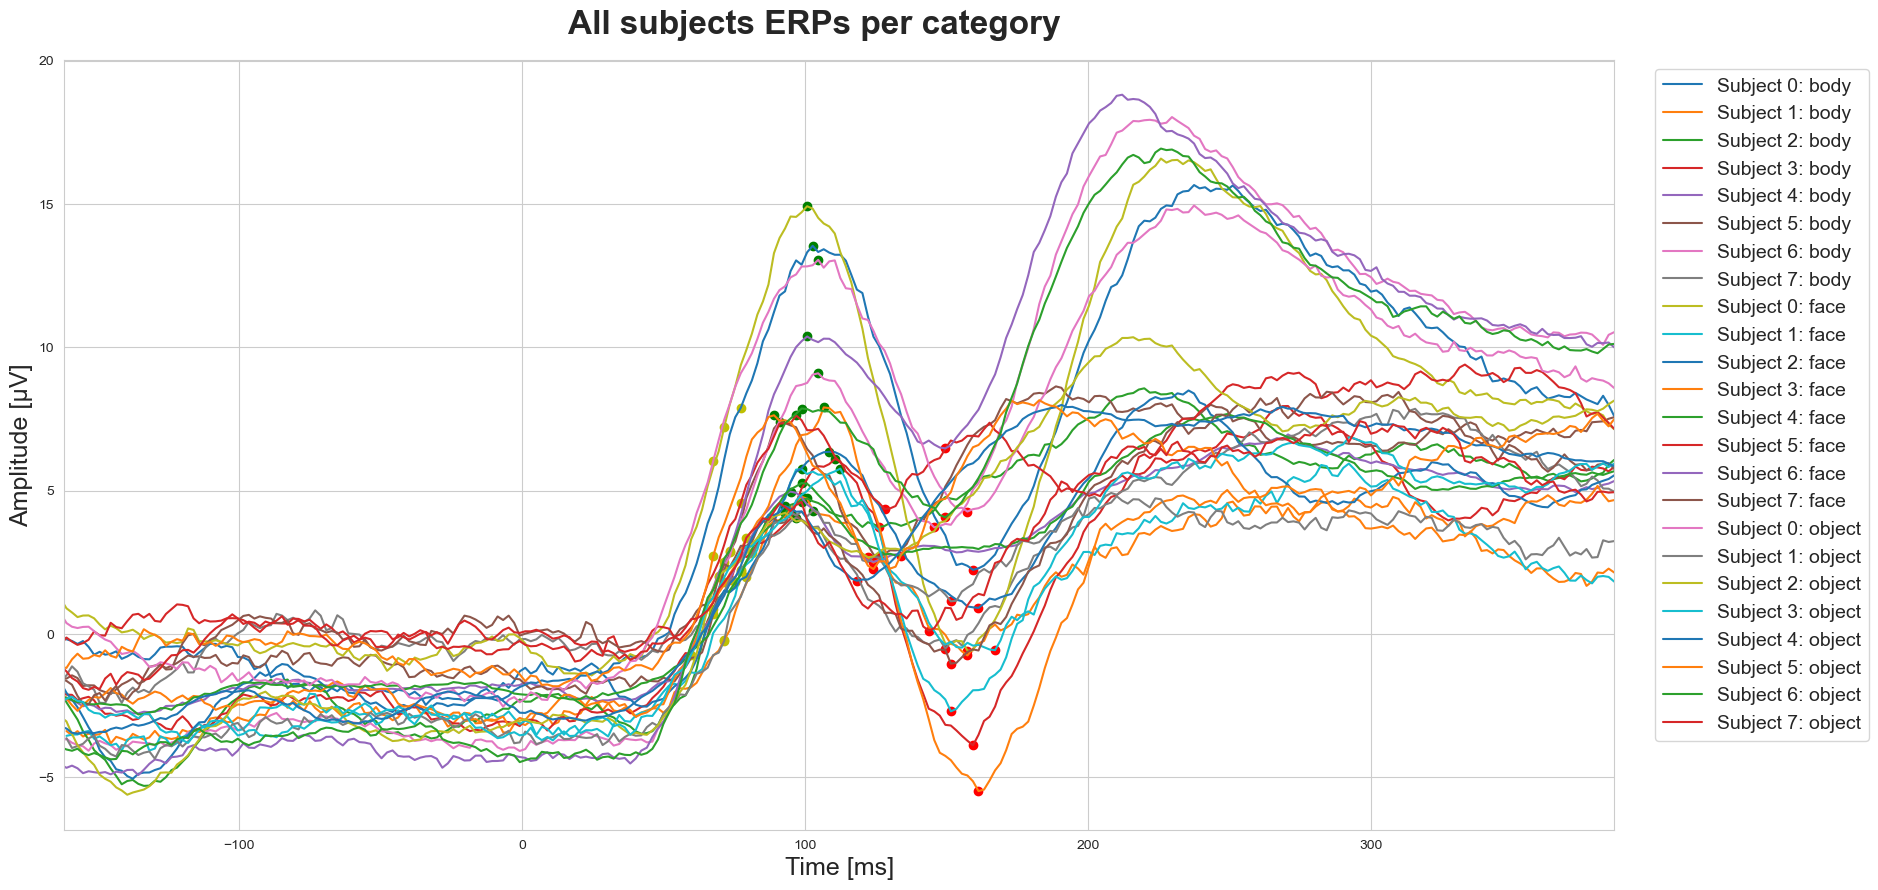

In [236]:
# Plot all participants' maximums and minimums
# plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(20,10))
fig.suptitle("All subjects ERPs per category",fontsize=24, y=0.93, fontweight='bold')
plt.rcParams.update({'font.size': 14})
for key in ch_keys:
    for participant in range(participant_count):
        df4 = df_cleaned[df_cleaned['subject'] == participant] # select participant
        plt.scatter(df4.subj_time, df4[key+'_min'], c='r')
        plt.scatter(df4.subj_time, df4[key+'_max'], c='g')
        plt.scatter(df4.subj_time, df4[key+'_grads_extrema_key_value'], c='y')
        line, = plt.plot(df4.subj_time, df4[key])
        line.set_label(f"Subject {participant}: {key}")

        # ax.set_ylim(-1,1)
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.set_ylabel("Amplitude [\u03BCV]", fontsize=18)
        ax.set_xlabel("Time [ms]", fontsize=18)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlim([cleaned_start_time, cleaned_end_time])
plt.show()

In [10]:
# inspect new dataframe
df_cleaned

body      face    object   subj_time  subject  body_min  body_max  \
0     5.915901  6.110841  5.858163 -311.295573      0.0       NaN       NaN   
1     6.088581  6.456994  6.140627 -309.342448      0.0       NaN       NaN   
2     6.139641  6.606117  6.448425 -307.389323      0.0       NaN       NaN   
3     6.593696  6.790761  6.460158 -305.436198      0.0       NaN       NaN   
4     6.589998  7.117500  6.645327 -303.483073      0.0       NaN       NaN   
...        ...       ...       ...         ...      ...       ...       ...   
2859  5.010485  5.210922  4.485417  421.126302      7.0       NaN       NaN   
2860  5.001881  5.355083  4.451282  423.079427      7.0       NaN       NaN   
2861  5.043113  5.256223  4.632553  425.032552      7.0       NaN       NaN   
2862  5.057186  5.056796  4.908361  426.985677      7.0       NaN       NaN   
2863  4.741613  5.175090  4.924191  428.938802      7.0       NaN       NaN   

      body_grads  body_grads_extrema  body_grads_extrema_key_value  face_min  \
0            NaN                 NaN                           NaN       NaN   
1            NaN                 NaN                           NaN       NaN   
2            NaN                 NaN                           NaN       NaN   
3            NaN                 NaN                           NaN       NaN   
4            NaN                 NaN                           NaN       NaN   
...          ...                 ...                           ...       ...   
2859         NaN                 NaN                           NaN       NaN   
2860         NaN                 NaN                           NaN       NaN   
2861         NaN                 NaN                           NaN       NaN   
2862         NaN                 NaN                           NaN       NaN   
2863         NaN                 NaN                           NaN       NaN   

      face_max  face_grads  face_grads_extrema  face_grads_extrema_key_value  \
0          NaN         NaN                 NaN                           NaN   
1          NaN         NaN                 NaN                           NaN   
2          NaN         NaN                 NaN                           NaN   
3          NaN         NaN                 NaN                           NaN   
4          NaN         NaN                 NaN                           NaN   
...        ...         ...                 ...                           ...   
2859       NaN         NaN                 NaN                           NaN   
2860       NaN         NaN                 NaN                           NaN   
2861       NaN         NaN                 NaN                           NaN   
2862       NaN         NaN                 NaN                           NaN   
2863       NaN         NaN                 NaN                           NaN   

      object_min  object_max  object_grads  object_grads_extrema  \
0            NaN         NaN           NaN                   NaN   
1            NaN         NaN           NaN                   NaN   
2            NaN         NaN           NaN                   NaN   
3            NaN         NaN           NaN                   NaN   
4            NaN         NaN           NaN                   NaN   
...          ...         ...           ...                   ...   
2859         NaN         NaN           NaN                   NaN   
2860         NaN         NaN           NaN                   NaN   
2861         NaN         NaN           NaN                   NaN   
2862         NaN         NaN           NaN                   NaN   
2863         NaN         NaN           NaN                   NaN   

      object_grads_extrema_key_value  
0                                NaN  
1                                NaN  
2                                NaN  
3                                NaN  
4                                NaN  
...                              ...  
2859                             NaN  
2860      

In [22]:
# select only needed columns for analysis
df_cleaned = df_cleaned[["body", "face", "object", "subj_time", "subject"]]#.melt(id_vars=["subj_time","subject"])
mask = (df_cleaned['subj_time'] >= cleaned_start_time) & (df_cleaned['subj_time'] <= cleaned_end_time)
df_masked_erps = df_cleaned.loc[mask]
df_masked4 = df_masked_erps.melt(id_vars=["subj_time","subject"])
df_masked4

subj_time  subject variable     value
0    -160.904948      0.0     body -0.182969
1    -158.951823      0.0     body -0.240746
2    -156.998698      0.0     body -0.344782
3    -155.045573      0.0     body -0.243672
4    -153.092448      0.0     body -0.445178
...          ...      ...      ...       ...
6739  378.157552      7.0   object  4.704927
6740  380.110677      7.0   object  4.960660
6741  382.063802      7.0   object  4.969170
6742  384.016927      7.0   object  4.934233
6743  385.970052      7.0   object  4.948795

[6744 rows x 4 columns]

## 4. ERPS grand averages

### 4.1 Visualize ERPs variability and mean across subjects

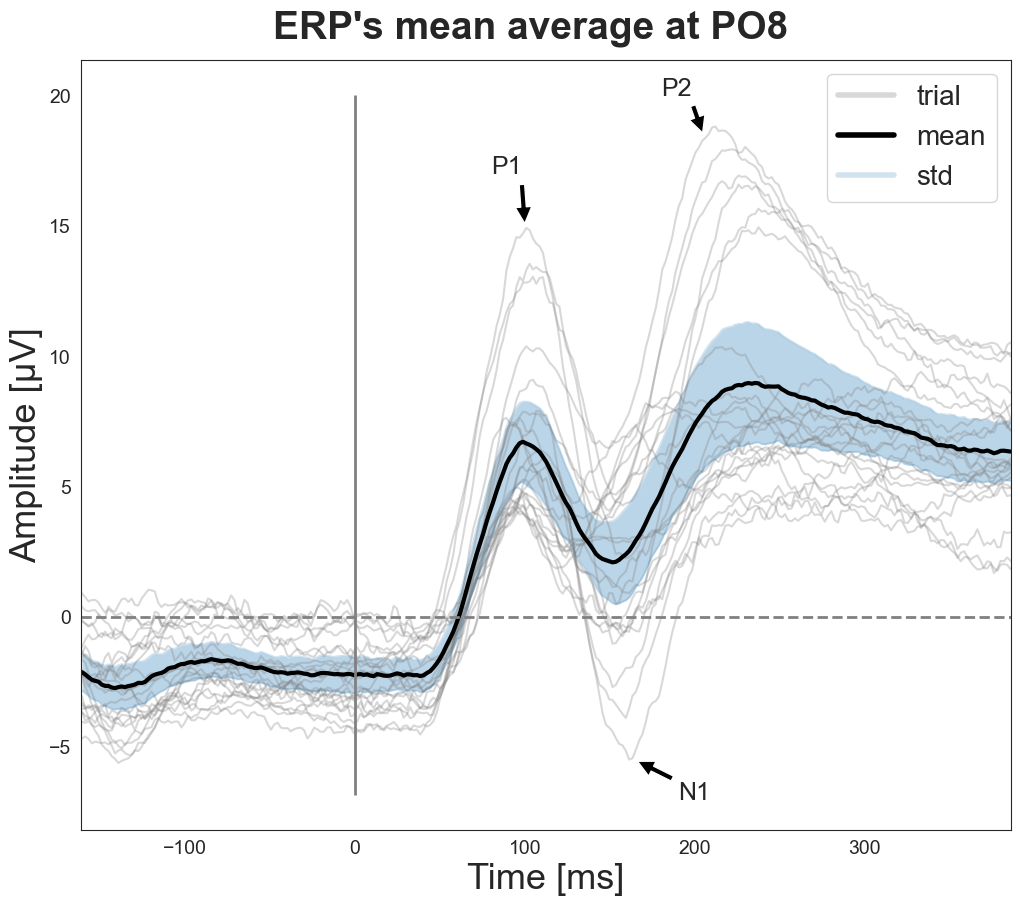

In [968]:
# Define variables to plot
y_mean = df_masked4.groupby(['subj_time'])['value'].mean()
x = y_mean.index
# Compute upper and lower bounds using chosen uncertainty measure: here
# it is a fraction of the standard deviation of measurements at each
# time point based on the unbiased sample variance
y_std = df_masked4.groupby(['subj_time']).std()['value']
error = 0.5*y_std
lower = y_mean - error
upper = y_mean + error
# Draw plot with error band and extra formatting to match seaborn style
fig, ax = plt.subplots(nrows=1, figsize=(12, 10))
plt.rcParams.update({'font.size': 14})
fig.suptitle("ERP's mean average at PO8",fontsize=28, y=0.93, fontweight='bold')

for key in ch_keys:
    for participant in range(participant_count):
        df4 = df_cleaned[df_cleaned['subject'] == participant]
        plt.plot(df4.subj_time, df4[key],label='trial', color='gray', alpha=0.3)
        plt.xlim([cleaned_start_time, cleaned_end_time])
g = sns.lineplot(x=x, y=y_mean, label='mean', alpha=1, linewidth=3, color='k')
ax.plot(x, lower, label='std', color='tab:blue', alpha=0.2)
ax.plot(x, upper, color='tab:blue', alpha=0.2)
ax.fill_between(x, lower, upper, alpha=0.3)
ax.set_xlabel('Time [ms]', fontsize=26)
ax.set_ylabel('Amplitude [\u03BCV]', fontsize=26)
ax.annotate('P1', xy=(100, 15), xytext=(80, 17), fontsize=18,
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('N1', xy=(165, -5.5), xytext=(190, -7), fontsize=18,
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('P2', xy=(205, 18.5), xytext=(180, 20), fontsize=18,
            arrowprops=dict(facecolor='black', shrink=0.05))
# obtain the handles and labels from the figure
handles, labels = plt.gca().get_legend_handles_labels()
# copie handles and labels
handles = [copy.copy(ha) for ha in handles ]
# set the linewidths to the copies
[ha.set_linewidth(4) for ha in handles ]
by_label = dict(zip(labels, handles))
# put the copies into the legend
leg = plt.legend(fontsize=20, title_fontsize='20', handles=by_label.values(), labels=by_label.keys())

# y min and max
ymin, ymax = g.get_ylim()
xmin, xmax = g.get_xlim()
g.vlines(x=0, ymin=ymin, ymax=ymax, colors=['gray'], lw=2)
g.hlines(y=0, xmin=xmin, xmax=xmax, colors=['gray'], ls='--', lw=2)
plt.savefig(data_path + "/images/"+"erps_mean_average_trial"+"."+format, format=format, dpi=1200)

### 4.2 Visualize ERPs grand categorical average

In [76]:
# original colors from previous analysis
# colors = dict(object=deep_pal[4], face=deep_pal[0], body=deep_pal[1])
# colors = dict(object=deep_pal[0], face=deep_pal[1], body=deep_pal[3])
# new colors for thesis
colors = dict(object="#046378", face="#D0465A", body="#C99756")

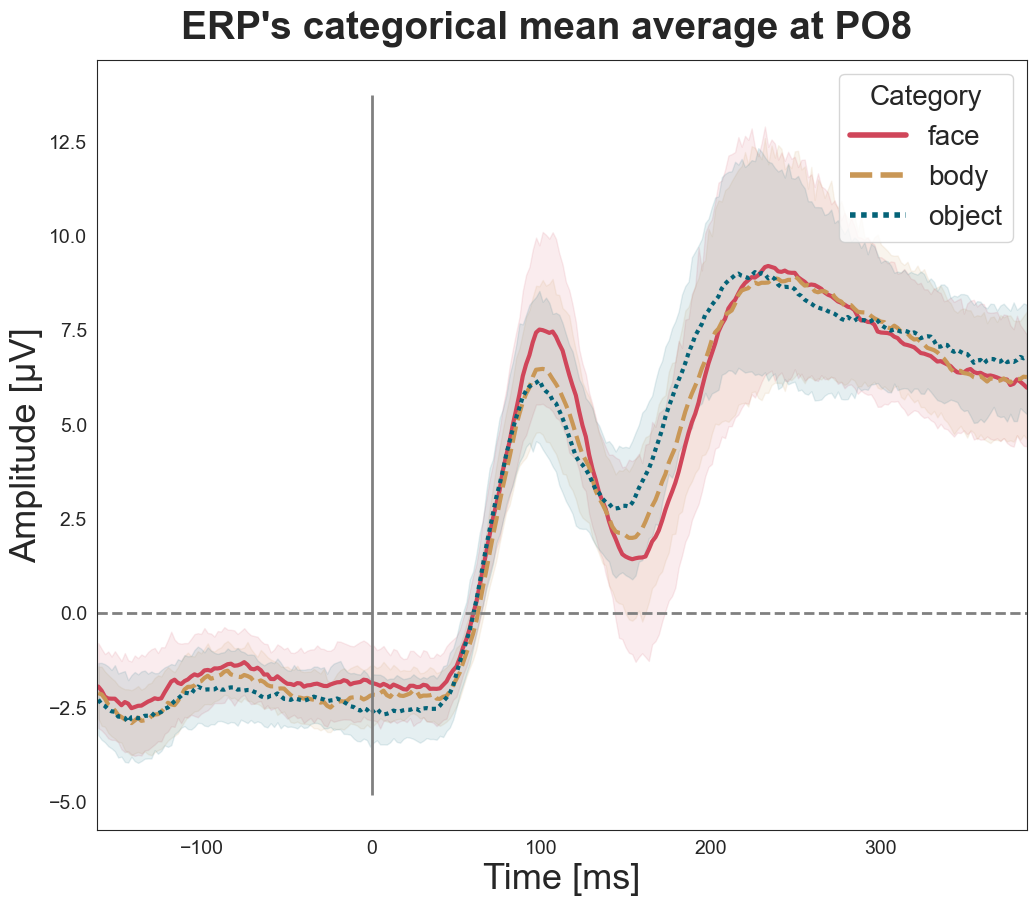

In [926]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 10))
plt.rcParams.update({'font.size': 14})
# time_window = df.loc[df['subject'] == 1, 'sub_time']
# time_window
fig.suptitle("ERP's categorical mean average at PO8",fontsize=28, y=0.93, fontweight='bold')
g = sns.lineplot(data= df_masked4, x='subj_time', y='value', hue='variable', linewidth=3,
                 style='variable',
                 style_order=['face','body','object'],
                 hue_order=['face','body','object'],
                 palette=colors,err_kws={"alpha": .1},ax=ax)
# g = sns.relplot(data=df_masked4, x="subj_time", y="value",
#                 hue="variable", style="variable", kind="line")
ax.set_ylabel("Amplitude [\u03BCV]", fontsize=26)
ax.set_xlabel("Time [ms]", fontsize=26)
ax.set_xlim(cleaned_start_time, cleaned_end_time)

# # obtain the handles and labels from the figure
handles, labels = ax.get_legend_handles_labels()
# copy the handles
handles = [copy.copy(ha) for ha in handles ]
# set the linewidths to the copies
[ha.set_linewidth(4) for ha in handles ]
# put the copies into the legend
leg = plt.legend(title='Category',fontsize=20, title_fontsize='20', handles=handles, labels=labels)
# y min and max
ymin, ymax = g.get_ylim()
xmin, xmax = g.get_xlim()
# vertical lines
g.vlines(x=0, ymin=ymin, ymax=ymax, colors=['gray'], lw=2)
g.hlines(y=0, xmin=xmin, xmax=xmax, colors=['gray'], ls='--', lw=2)
format='pdf'
plt.savefig(data_path + "/images/"+"erps_mean_average_category"+"."+format, format=format, dpi=1200)

## 5. ERPs Statistics

###  5.1 Categorical means

In [727]:
df_min_max.groupby('key')['max'].agg(['count','mean','std'])

count         mean          std
key                                    
body        8 6.8367662430 3.1791595993
face        8 7.8046430945 3.4413577054
object      8 6.4915968180 3.0305653064

In [754]:
df_mean_summary = df_min_max.rename(columns={'max':'P1','min':'N1','diff':'[\u03BCV] difference'})
df_mean_summary

subject     key            N1            P1  [μV] difference
0        0    body  2.2399916649 13.5442171097    11.3042254448
1        0    face -0.5760124326 14.9229288101    15.4989412427
2        0  object  4.2732424736 13.0519399643     8.7786974907
3        1    body -0.7455092669  4.7903308868     5.5358401537
4        1    face -0.5618327260  5.7534666061     6.3152993321
5        1  object  1.1412217617  4.3072123528     3.1659905910
6        2    body  3.7351179123  4.7310996056     0.9959816933
7        2    face  0.9126566648  6.3574323654     5.4447757006
8        2  object  2.6793048382  4.2299718857     1.5506670475
9        3    body -3.8813145161  6.1048555374     9.9861700535
10       3    face -5.4775185585  7.9058895111    13.3834080696
11       3  object -2.6951313019  5.7701201439     8.4652514458
12       4    body  2.5199246407  4.9694738388     2.4495491982
13       4    face  2.7387106419  5.2683405876     2.5296299458
14       4  object  1.8611074686  4.4657731056     2.6046656370
15       5    body  2.6878962517  7.3956775665     4.7077813148
16       5    face  4.3645868301  7.6255187988     3.2609319687
17       5  object  2.2673714161  7.6320424080     5.3646709919
18       6    body  3.7192709446  9.0962066650     5.3769357204
19       6    face  6.4781732559 10.3797674179     3.9015941620
20       6  object  4.0718574524  7.8675541878     3.7956967354
21       7    body -0.5057152510  4.0622687340     4.5679839849
22       7    face -1.0317906141  4.2238006592     5.2555912733
23       7  object  0.1160708889  4.6081604958     4.4920896068

In [884]:
df_means_summary = df_mean_summary.groupby('key')[['N1','P1','[\u03BCV] difference']].agg(['count','mean','std'])
dfi.export(df_means_summary, 'data/erps/images/means_summary.png')
df_means_summary

75298 bytes written to file /var/folders/yy/s3wgmwl10fg_cc7cb_s92snr0000gn/T/tmpqonytdj5/temp.png


N1                P1             [μV] difference            
       count  mean   std count  mean   std           count  mean   std
key                                                                   
body       8 1.221 2.681     8 6.837 3.179               8 5.616 3.481
face       8 0.856 3.688     8 7.805 3.441               8 6.949 4.817
object     8 1.714 2.258     8 6.492 3.031               8 4.777 2.638

In [881]:
# calculate the difference in mean amplitude
face_mean_diff = df_mean_summary[df_mean_summary['key']=='face']['[\u03BCV] difference'].mean()
body_mean_diff = df_mean_summary[df_mean_summary['key']=='body']['[\u03BCV] difference'].mean()
object_mean_diff = df_mean_summary[df_mean_summary['key']=='object']['[\u03BCV] difference'].mean()
df_mean_cat_diff = pd.DataFrame({'categories':['face-object','face-body','body-object'],
                                 'Mean amplitude difference [\u03BCV] ':[face_mean_diff-object_mean_diff,
                                                                   face_mean_diff-body_mean_diff,
                                                                   body_mean_diff-object_mean_diff]})

dfi.export(df_mean_cat_diff, 'data/erps/images/mean_category_differences.png')
df_mean_cat_diff

61938 bytes written to file /var/folders/yy/s3wgmwl10fg_cc7cb_s92snr0000gn/T/tmpdx6ooymb/temp.png


categories  Mean amplitude difference [μV] 
0  face-object                     2.1715552686
1    face-body                     1.3332130164
2  body-object                     0.8383422522

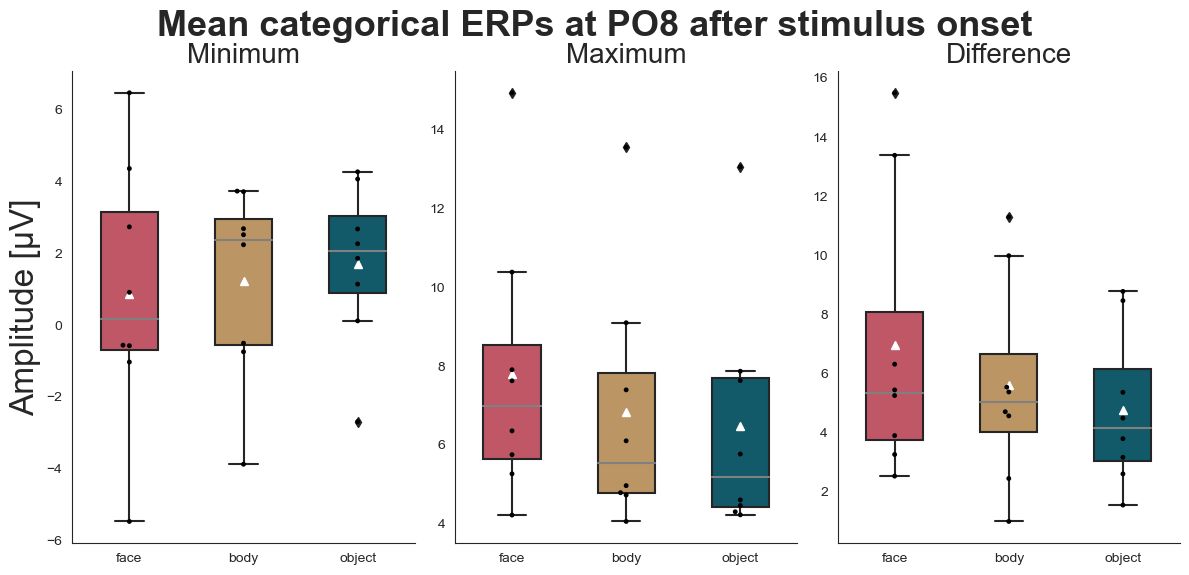

In [30]:
fig, ax = plt.subplots(figsize=(12,6), ncols=3, nrows=1)
plt.rcParams.update({'font.size': 10})
fig.suptitle("Mean categorical ERPs at PO8 after stimulus onset",fontsize=26, y=0.95, fontweight='bold')

# MINIMUM
sns.boxplot(data=df_min_max, x= 'key',y='min',order=['face','body','object'], showmeans=True, palette=colors, width=0.5,
            meanprops={"marker":"^",
                       "markerfacecolor":"white",
                       "markeredgecolor":"white",
                      "markersize":"6"},
            medianprops={"color": "gray"}, ax=ax[0])
sns.swarmplot(data=df_min_max, x= 'key',y='min', order=['face','body','object'],palette={'black', 'black', 'black'}, size=3.5, ax=ax[0])
ax[0].set_title("Minimum", fontsize=20)
ax[0].set_ylabel("Amplitude [\u03BCV]", fontsize=24)
ax[0].set_xlabel(None, fontsize=18)

# MAXIMUM
sns.boxplot(data=df_min_max, x= 'key',y='max',order=['face','body','object'], showmeans=True,palette=colors,width=0.5,
            meanprops={"marker":"^",
                       "markerfacecolor":"white",
                       "markeredgecolor":"white",
                      "markersize":"6"},
            medianprops={"color": "gray"}, ax=ax[1])
sns.swarmplot(data=df_min_max, x= 'key',y='max', order=['face','body','object'],palette={'black', 'black', 'black'}, size=3.5, ax=ax[1])
ax[1].set_title("Maximum", fontsize=20)
ax[1].set_ylabel(None, fontsize=18)
ax[1].set_xlabel(None, fontsize=18)

# DIFFERENCE in amplitude
sns.boxplot(data=df_min_max, x= 'key',y='diff',order=['face','body','object'], showmeans=True,palette=colors,width=0.5,
            meanprops={"marker":"^",
                       "markerfacecolor":"white",
                       "markeredgecolor":"white",
                      "markersize":"6"},
            medianprops={"color": "gray"}, ax=ax[2])
sns.swarmplot(data=df_min_max, x= 'key',y='diff', order=['face','body','object'],palette={'black', 'black', 'black'}, size=3.5, ax=ax[2])
ax[2].set_title("Difference", fontsize=20)
ax[2].set_ylabel(None, fontsize=18)
ax[2].set_xlabel(None, fontsize=18)
sns.despine(top=True)
plt.tight_layout()
# plt.savefig(data_path + "/images/"+"NEWER_erps_activations_differences"+"."+format, format=format, dpi=1200)

In [16]:
df_means2 = df_min_max.melt(id_vars=["subject","key"])
df_means2

subject     key variable     value
0        0    body      min  2.239992
1        0    face      min -0.576012
2        0  object      min  4.273242
3        1    body      min -0.745509
4        1    face      min -0.561833
..     ...     ...      ...       ...
67       6    face     diff  3.901594
68       6  object     diff  3.795697
69       7    body     diff  4.567984
70       7    face     diff  5.255591
71       7  object     diff  4.492090

[72 rows x 4 columns]

(-10.0, 18.0)

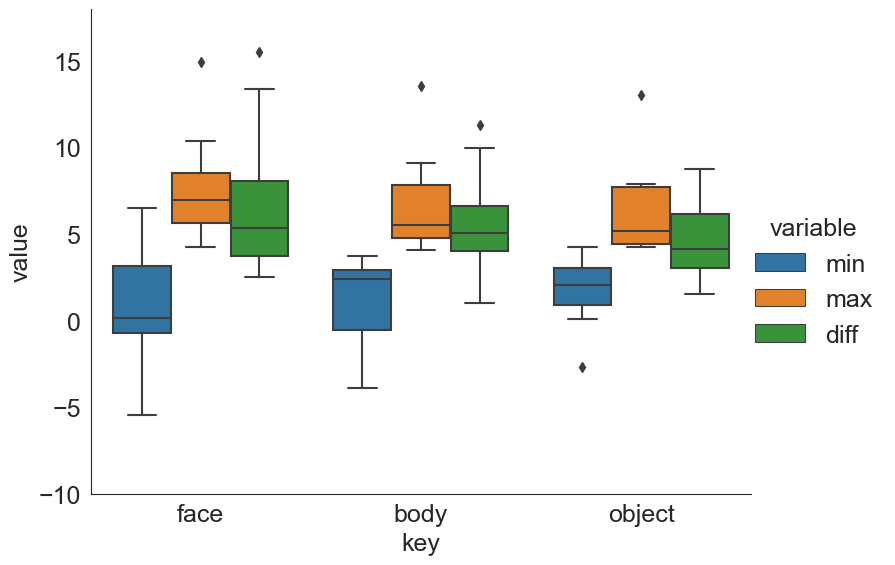

In [17]:
sns.catplot(x='key', y='value',
                 hue="variable",
                data=df_means2, kind="box",order=['face','body','object'],
            height=6, aspect=1.3)
plt.ylim(-10, 18)

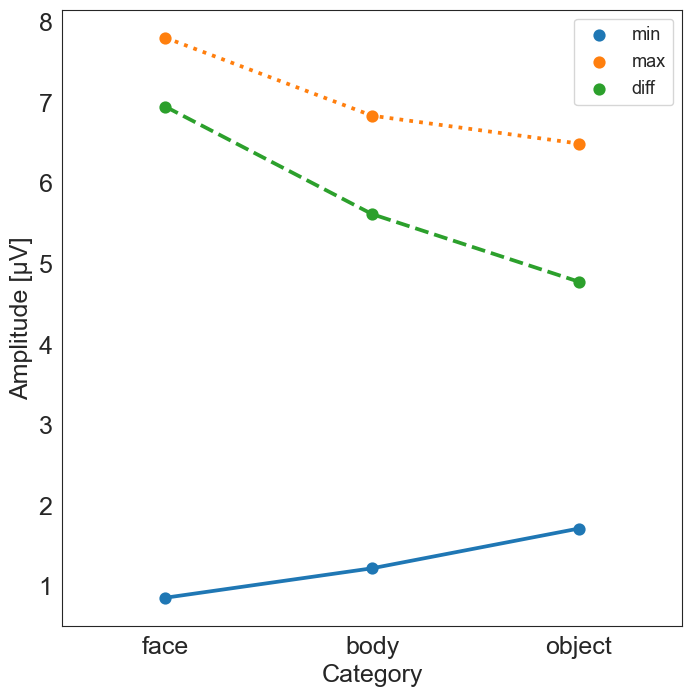

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
sns.pointplot(data=df_means2, x='key',y='value', order=['face','body','object'], hue='variable',linestyles=['-', ':', '--'],ci=None) # TODO: make hue different per category to show in legend
# sns.lineplot(data=df_means2,x='key',y='value', hue='variable')
# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_ylabel("Amplitude [\u03BCV]", fontsize=18)
ax.set_xlabel("Category", fontsize=18)
plt.legend(fontsize=13, title_fontsize='12')
# ax.set_ylim(0,10)
plt.savefig(data_path + "/images/"+"erps_activations_line_diff"+"."+format, format=format, dpi=1200)

### 5.2 Means per subject

(0.0, 12.0)

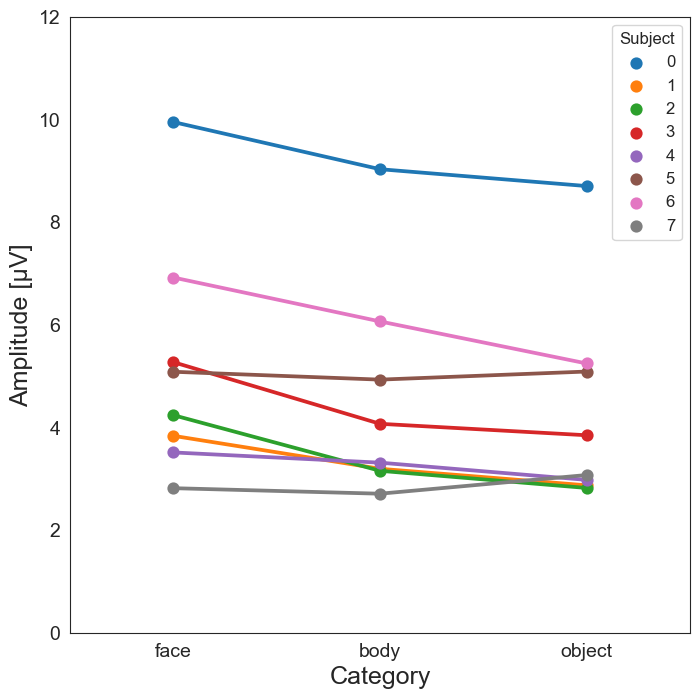

In [634]:
# sns.pointplot(data=df_means2, x= 'variable',y='value', hue='subject', order=['face','body','object']) # By subject by category
fig, ax = plt.subplots(figsize=(8,8))
sns.pointplot(data=df_means2, x='key',y='value', hue='subject',order=['face','body','object'],ci=None) # TODO: make hue different per category to show in legend
# sns.lineplot(data=df_means2,x='key',y='value', hue='variable')
# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_ylabel("Amplitude [\u03BCV]", fontsize=18)
ax.set_xlabel("Category", fontsize=18)
plt.legend(title="Subject",fontsize=12, title_fontsize='12')
ax.set_ylim(0,12)

In [712]:
df_means = df_min_max.groupby(['key']).mean()
df_means

min          max         diff
key                                          
body   1.2212077975 6.8367662430 5.6155584455
face   0.8558716327 7.8046430945 6.9487714618
object 1.7143806247 6.4915968180 4.7772161933

In [239]:
df_min_max.query('key == "face"').describe()

min        max       diff
count  8.000000   8.000000   8.000000
mean   0.855872   7.804643   6.948771
std    3.687914   3.441358   4.817444
min   -5.477519   4.223801   2.529630
25%   -0.689957   5.632185   3.741429
50%    0.175412   6.991476   5.350183
75%    3.145180   8.524359   8.082327
max    6.478173  14.922929  15.498941

In [468]:
df_min_max.query('key == "body"').describe()

min        max       diff
count  8.000000   8.000000   8.000000
mean   1.221208   6.836766   5.615558
std    2.681199   3.179160   3.480806
min   -3.881315   4.062269   0.995982
25%   -0.565664   4.775523   4.038375
50%    2.379958   5.537165   5.042359
75%    2.945740   7.820810   6.648423
max    3.735118  13.544217  11.304225

In [469]:
df_min_max.query('key == "object"').describe()

min        max      diff
count  8.000000   8.000000  8.000000
mean   1.714381   6.491597  4.777216
std    2.258026   3.030565  2.638449
min   -2.695131   4.229972  1.550667
25%    0.884934   4.426133  3.025659
50%    2.064239   5.189140  4.143893
75%    3.027443   7.690920  6.139816
max    4.273242  13.051940  8.778697

### 5.3 Hypothesis Testing

We will test different hypotheses:

>**1.** **Categorical mean differences for component P1**
>>**h0:** There is no increase differences at P1 in average ERP responses to face, object, and body stimuli across 8 subjects
>>**h1:** There is an increase differences at P1 in average ERP responses to face, object, and body stimuli across 8 subjects

>**2.** **Categorical mean differences for component N1**
>>**h0:** There is no deflection difference at N1 in average ERP responses to face, object, and body stimuli across 8 subjects
>>**h1:** There is a deflection difference at N1 in average ERP responses to face, object, and body stimuli across 8 subjects

>**3.** **Multiple comparison of categories at P1**
>>**h0:** There is no increase difference between face-object, face-body, and body-object category pairs at P1
>>**h1:** There is an increase difference between face-object, face-body, and body-object category pairs at P1

>**4.** **Single-Rank comparison face-object at P1**
>>**h0:** There is no increase difference between face and object stimuli
>>**h1:** There is an increase difference between face and object stimuli

>**5.** **Single-Rank comparison face-body at P1**
>>**h0:** There is no increase difference between face and body stimuli
>>**h1:** There is an increase difference between face and body stimuli

>**6.** **Single-Rank comparison body-object at P1**
>>**h0:** There is no increase difference between body and object stimuli
>>**h1:** There is an increase difference between body and object stimuli

In [237]:
import researchpy as rp
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import AnovaRM

In [353]:
# If we want to test significance for face vs. object categories alone
# df_minmax = df_min_max[~df_min_max['key'].str.contains('body')].rename(columns={'key':'category'})
# df with all categories
df_minmax = df_min_max.rename(columns={'key':'category'})
df_minmax

subject category       min        max       diff
0        0     body  2.239992  13.544217  11.304225
1        0     face -0.576012  14.922929  15.498941
2        0   object  4.273242  13.051940   8.778697
3        1     body -0.745509   4.790331   5.535840
4        1     face -0.561833   5.753467   6.315299
5        1   object  1.141222   4.307212   3.165991
6        2     body  3.735118   4.731100   0.995982
7        2     face  0.912657   6.357432   5.444776
8        2   object  2.679305   4.229972   1.550667
9        3     body -3.881315   6.104856   9.986170
10       3     face -5.477519   7.905890  13.383408
11       3   object -2.695131   5.770120   8.465251
12       4     body  2.519925   4.969474   2.449549
13       4     face  2.738711   5.268341   2.529630
14       4   object  1.861107   4.465773   2.604666
15       5     body  2.687896   7.395678   4.707781
16       5     face  4.364587   7.625519   3.260932
17       5   object  2.267371   7.632042   5.364671
18       6     body  3.719271   9.096207   5.376936
19       6     face  6.478173  10.379767   3.901594
20       6   object  4.071857   7.867554   3.795697
21       7     body -0.505715   4.062269   4.567984
22       7     face -1.031791   4.223801   5.255591
23       7   object  0.116071   4.608160   4.492090

In [694]:
# For all statistical tests we assume alpha = 0.05
alpha = 0.05
# create dataframe for each category
face = df_minmax[df_minmax['category'] == 'face'].reset_index(drop=True).rename(columns={'min':'face_min','max': 'face_max'})
body = df_minmax[df_minmax['category'] == 'body'].reset_index(drop=True).rename(columns={'min':'body_min','max': 'body_max'})
object = df_minmax[df_minmax['category'] == 'object'].reset_index(drop=True).rename(columns={'min':'object_min','max': 'object_max'})

In [695]:
face

subject category      face_min      face_max          diff
0       0     face -0.5760124326 14.9229288101 15.4989412427
1       1     face -0.5618327260  5.7534666061  6.3152993321
2       2     face  0.9126566648  6.3574323654  5.4447757006
3       3     face -5.4775185585  7.9058895111 13.3834080696
4       4     face  2.7387106419  5.2683405876  2.5296299458
5       5     face  4.3645868301  7.6255187988  3.2609319687
6       6     face  6.4781732559 10.3797674179  3.9015941620
7       7     face -1.0317906141  4.2238006592  5.2555912733

In [560]:
# drop diff columns since we do not need it
df_min_max_long = df_minmax.melt(['subject','category'], var_name="component",value_name='signal')
df_min_max_long

subject category component    signal
0        0     body       min  2.239992
1        0     face       min -0.576012
2        0   object       min  4.273242
3        1     body       min -0.745509
4        1     face       min -0.561833
..     ...      ...       ...       ...
67       6     face      diff  3.901594
68       6   object      diff  3.795697
69       7     body      diff  4.567984
70       7     face      diff  5.255591
71       7   object      diff  4.492090

[72 rows x 4 columns]

In [762]:
# Min-Max normalization for signal
w = df_min_max_long['signal'].agg(['min', 'max'])
norm = (df_min_max_long['signal'] - w['min']) / (w['max'] - w['min'])
df_min_max_long['norm_signal'] = norm
df_min_max_long

subject category component        signal  norm_signal
0        0     body       min  2.2399916649 0.3679129032
1        0     face       min -0.5760124326 0.2336669854
2        0   object       min  4.2732424736 0.4648430252
3        1     body       min -0.7455092669 0.2255866498
4        1     face       min -0.5618327260 0.2343429673
..     ...      ...       ...           ...          ...
67       6     face      diff  3.9015941620 0.4471256260
68       6   object      diff  3.7956967354 0.4420772324
69       7     body      diff  4.5679839849 0.4788940860
70       7     face      diff  5.2555912733 0.5116740353
71       7   object      diff  4.4920896068 0.4752760122

[72 rows x 5 columns]

In [768]:
# create dataframe for each category at max (P100) and min (N170) signals
face_group_max = df_min_max_long[(df_min_max_long['category'] == 'face') & (df_min_max_long['component'] == 'max')]
face_group_min = df_min_max_long[(df_min_max_long['category'] == 'face') & (df_min_max_long['component'] == 'min')]
body_group_max = df_min_max_long[(df_min_max_long['category'] == 'body') & (df_min_max_long['component'] == 'max')]
body_group_min = df_min_max_long[(df_min_max_long['category'] == 'body') & (df_min_max_long['component'] == 'min')]
object_group_max = df_min_max_long[(df_min_max_long['category'] == 'object') & (df_min_max_long['component'] == 'max')]
object_group_min = df_min_max_long[(df_min_max_long['category'] == 'object') & (df_min_max_long['component'] == 'min')]

In [769]:
object_group_min

subject category component        signal  norm_signal
2        0   object       min  4.2732424736 0.4648430252
5        1   object       min  1.1412217617 0.3155318096
8        2   object       min  2.6793048382 0.3888560545
11       3   object       min -2.6951313019 0.1326433194
14       4   object       min  1.8611074686 0.3498505514
17       5   object       min  2.2673714161 0.3692181640
20       6   object       min  4.0718574524 0.4552425005
23       7   object       min  0.1160708889 0.2666603183

#### 5.3.1 Calculating assumed normality, sphericity, and homogeneity of variance.

In [771]:
groups = [face_group_max['signal'], body_group_max['signal'], object_group_max['signal'],face_group_min['signal'], body_group_min['signal'], object_group_min['signal']]

name = ['face-max', 'body-max', 'object-max','face-min','body-min','object-min']

for i in range(len(groups)):
    stat, p = stats.shapiro(groups[i])

    print('{}: stat={:0.3f}, p={:0.3f}'.format(name[i], stat, p))
    if p > alpha:
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')

face-max: stat=0.880, p=0.186
Probably Gaussian
body-max: stat=0.825, p=0.052
Probably Gaussian
object-max: stat=0.781, p=0.018
Probably not Gaussian
face-min: stat=0.969, p=0.889
Probably Gaussian
body-min: stat=0.864, p=0.133
Probably Gaussian
object-min: stat=0.930, p=0.512
Probably Gaussian


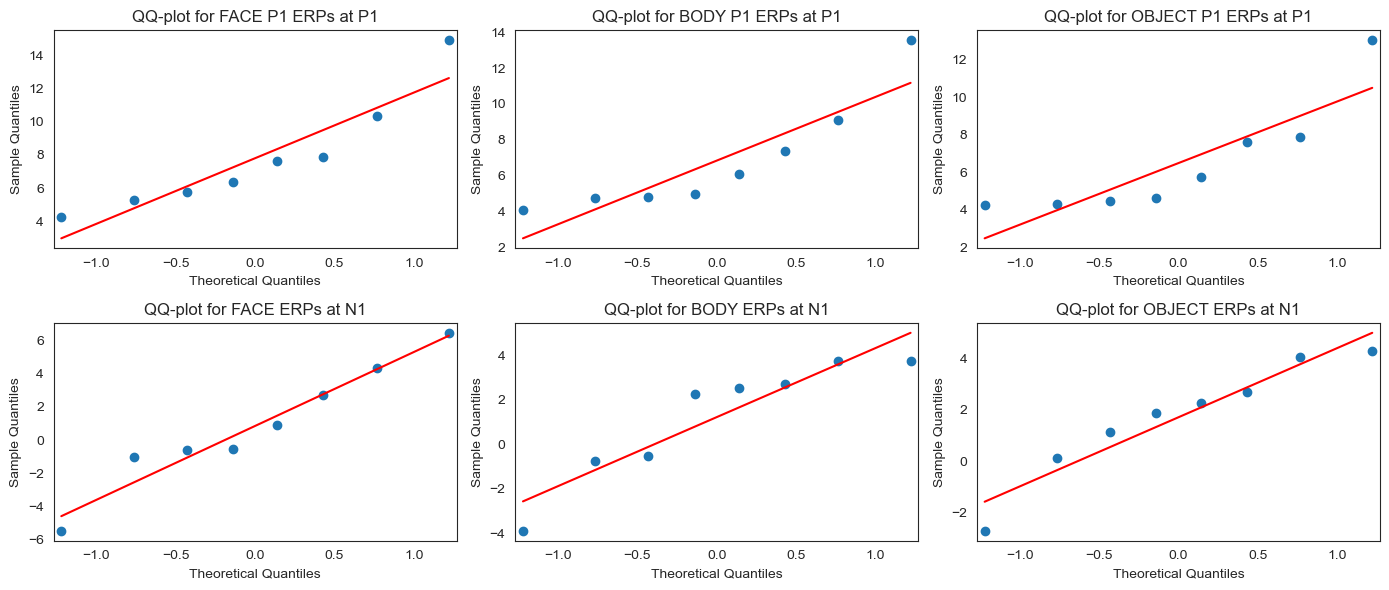

In [825]:
# TODO: Create QQ-plot for the Voltage ERP signals
fig, ax = plt.subplots(2,3,figsize=(14,6))
# MAX face
sm.qqplot(face['face_max'], line='r', ax=ax[0,0])
ax[0,0].set(title='QQ-plot for FACE ERPs at P1')
# body
sm.qqplot(body['body_max'], line='r', ax=ax[0,1])
ax[0,1].set(title='QQ-plot for BODY ERPs at P1')
# object
sm.qqplot(object['object_max'], line='r', ax=ax[0,2])
ax[0,2].set(title='QQ-plot for OBJECT ERPs at P1')
# MIN plots
sm.qqplot(face['face_min'], line='r', ax=ax[1,0])
ax[1,0].set(title='QQ-plot for FACE ERPs at N1')
# body
sm.qqplot(body['body_min'], line='r', ax=ax[1,1])
ax[1,1].set(title='QQ-plot for BODY ERPs at N1')
# object
sm.qqplot(object['object_min'], line='r', ax=ax[1,2])
ax[1,2].set(title='QQ-plot for OBJECT ERPs at N1')
plt.tight_layout()
# plt.show()
plt.savefig(data_path + "/images/"+"QQ_plots_per_category"+"."+format, format=format, dpi=1200)

In [810]:
# TODO: Extract the response times
g1 = face_group_max['signal'].to_numpy()
g2 = body_group_max['signal'].to_numpy()
g3 = object_group_max['signal'].to_numpy()
g4 = face_group_min['signal'].to_numpy()
g5 = body_group_min['signal'].to_numpy()
g6 = object_group_min['signal'].to_numpy()

# TODO: Calculate the differences between all combinations and test it via Levene's test
stat, p = stats.levene(g1-g2, g1-g3, g1-g4, g1-g5,g1-g6,g2-g3, g2-g4,g2-g5,g2-g6, g3-g4,g3-g5,g3-g6,g4-g5,g4-g6,g5-g6)

print('stat={:0.3f}, p={:0.3f}'.format(stat, p))
if p > alpha:
    print('Sphericity is probably given')
else:
    print('Sphericity is probably not given')

stat=1.538, p=0.110
Sphericity is probably given


In [676]:
df_min_max_long

subject category component        signal  norm_signal
0        0     body       min  2.2399916649 0.3679129032
1        0     face       min -0.5760124326 0.2336669854
2        0   object       min  4.2732424736 0.4648430252
3        1     body       min -0.7455092669 0.2255866498
4        1     face       min -0.5618327260 0.2343429673
..     ...      ...       ...           ...          ...
67       6     face      diff  3.9015941620 0.4471256260
68       6   object      diff  3.7956967354 0.4420772324
69       7     body      diff  4.5679839849 0.4788940860
70       7     face      diff  5.2555912733 0.5116740353
71       7   object      diff  4.4920896068 0.4752760122

[72 rows x 5 columns]

### 5.4 Wilcoxon Signed-Rank Test (non-parametric)

In [681]:
# WILCOXON METHOD 1 # LITTLE DESCRIPTIVE so tried the method below
# from scipy.stats import wilcoxon
# res_max_face_ob = wilcoxon(x=face['face_max'], y=object['object_max'])
# res_max_face_body = wilcoxon(x=face['face_max'], y=body['body_max'])
# res_max_ob_body = wilcoxon(x=object['object_max'], y=body['body_max'])
# print(res_max_face_ob, res_max_face_body, res_max_ob_body, sep = "\n"*2)

WilcoxonResult(statistic=3.0, pvalue=0.0390625)

WilcoxonResult(statistic=0.0, pvalue=0.0078125)

WilcoxonResult(statistic=8.0, pvalue=0.1953125)


#### 5.4.1 Wilcoxon method 2 using researchpy
This is a more descriptive approach

##### 5.4.1.1 Wilcoxon for P1

In [867]:
# FACE-OBJECT (FO) P1
desc_FO_p1, result_FO_p1 = rp.ttest(face['face_max'], object['object_max'],
                                                 equal_variances= False, paired= True)
result_FO_p1
dfi.export(result_FO_p1, 'data/erps/images/wilcoxonResult_FO_p1.png')

90964 bytes written to file /var/folders/yy/s3wgmwl10fg_cc7cb_s92snr0000gn/T/tmpkw1m4rjf/temp.png


In [870]:
result_FO_p1

Wilcoxon signed-rank test      results
0      Mean for face_max =  7.8046430945
1    Mean for object_max =  6.4915968180
2                W value =  3.0000000000
3                Z value =  2.1004000000
4                p value =  0.0391000000
5        Rank-Biserial r =  0.8333000000
6              Pearson r =  0.7426000000

In [868]:
# FACE-BODY (FB) P1
desc_FB_p1, result_FB_p1 = rp.ttest(face['face_max'], body['body_max'],
                                                 equal_variances= False, paired= True)
result_FB_p1
dfi.export(result_FB_p1, 'data/erps/images/wilcoxonResult_FB_p1.png')

87591 bytes written to file /var/folders/yy/s3wgmwl10fg_cc7cb_s92snr0000gn/T/tmpw5r16q_x/temp.png


In [871]:
result_FB_p1

Wilcoxon signed-rank test      results
0      Mean for face_max =  7.8046430945
1      Mean for body_max =  6.8367662430
2                W value =  0.0000000000
3                Z value =  2.5205000000
4                p value =  0.0078000000
5        Rank-Biserial r =  1.0000000000
6              Pearson r =  0.8911000000

In [869]:
# BODY-OBJECT (BO) P1
desc_BO_p1, result_BO_p1 = rp.ttest(body['body_max'], object['object_max'],equal_variances= False, paired= True)
result_BO_p1
dfi.export(result_BO_p1, 'data/erps/images/wilcoxonResult_BO_p1.png')

92029 bytes written to file /var/folders/yy/s3wgmwl10fg_cc7cb_s92snr0000gn/T/tmpi0v15f2s/temp.png


In [872]:
result_BO_p1

Wilcoxon signed-rank test      results
0      Mean for body_max =  6.8367662430
1    Mean for object_max =  6.4915968180
2                W value =  8.0000000000
3                Z value =  1.4003000000
4                p value =  0.1953000000
5        Rank-Biserial r =  0.5556000000
6              Pearson r =  0.4951000000

##### 5.4.1.2 Wilcoxon for N1

In [706]:
# FACE-OBJECT (FO) N1
desc_FO_N1, result_FO_N1 = rp.ttest(face['face_min'], object['object_min'],equal_variances= False, paired= True)
result_FO_N1
# FACE-BODY (FB) N1
desc_FB_n1, result_FB_n1 = rp.ttest(face['face_min'], body['body_min'],equal_variances= False, paired= True)
result_FB_n1
# BODY-OBJECT (BO) N1
desc_BO_n1, result_BO_n1 = rp.ttest(body['body_min'], object['object_min'],equal_variances= False, paired= True)
result_BO_n1
# dfi.export(result_FO_N1, 'data/erps/images/wilcoxonResult_FO_p1.png')

Wilcoxon signed-rank test       results
0      Mean for face_min =   0.8558716327
1    Mean for object_min =   1.7143806247
2                W value =  12.0000000000
3                Z value =  -0.8402000000
4                p value =   0.4609000000
5        Rank-Biserial r =  -0.3333000000
6              Pearson r =  -0.2970000000

### 5.5 ANOVA

In [565]:
df_min_max_long

subject category component    signal  norm_signal
0        0     body       min  2.239992     0.367913
1        0     face       min -0.576012     0.233667
2        0   object       min  4.273242     0.464843
3        1     body       min -0.745509     0.225587
4        1     face       min -0.561833     0.234343
..     ...      ...       ...       ...          ...
67       6     face      diff  3.901594     0.447126
68       6   object      diff  3.795697     0.442077
69       7     body      diff  4.567984     0.478894
70       7     face      diff  5.255591     0.511674
71       7   object      diff  4.492090     0.475276

[72 rows x 5 columns]

In [549]:
# TODO: Perform a two-way repeated measures ANOVA (Pr > F = p-value)
# anovarm = AnovaRM(df_min_max_long,'norm_signal','subject',within=['category','component'])#, aggregate_func='mean')
# fit = anovarm.fit()
# print(fit)

                     Anova
                   F Value Num DF  Den DF Pr > F
------------------------------------------------
category            0.4433 2.0000 14.0000 0.6506
component          21.7515 1.0000  7.0000 0.0023
category:component  3.5425 2.0000 14.0000 0.0569



In [845]:
# TODO: Perform a one-way repeated measures ANOVA (Pr > F = p-value)
anovarm = AnovaRM(df_min_max_long[df_min_max_long['component'] == 'min'],'norm_signal','subject',within=['category'])#, aggregate_func='mean')
results = anovarm.fit()
print(results.summary())
# save the results as latex table
# print(results.summary().as_latex())

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
category  0.7680 2.0000 14.0000 0.4825



In [971]:
# TODO: Perform a one-way repeated measures ANOVA (Pr > F = p-value)
anovarm = AnovaRM(df_min_max_long[df_min_max_long['component'] == 'max'], depvar='norm_signal',subject='subject',within=['category'], aggregate_func='mean')
fit = anovarm.fit()
print(fit.summary())
# save the results as latext table
# print(fit.summary().as_latex())

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
category 11.9462 2.0000 14.0000 0.0009



### 5.6 Post-hoc analysis (multiple comparison)

In [970]:
# Multiple comparison of categories at P1
# Using Tukey-test HSD
from statsmodels.stats.multicomp import MultiComparison

multi_comp = MultiComparison(df_min_max_long[df_min_max_long['component'] == 'max']['signal'], df_min_max_long[df_min_max_long['component'] == 'max']['category'])
post_hoc_res = multi_comp.tukeyhsd()
print(post_hoc_res.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  body   face   0.9679 0.8212 -3.0921 5.0279  False
  body object  -0.3452  0.975 -4.4052 3.7148  False
  face object   -1.313  0.698 -5.3731  2.747  False
---------------------------------------------------


### 5.7 Trying a GLM

In [976]:
glm_test_df = df_min_max_long[df_min_max_long['component'] == 'max']## 0r: [['subject','category','signal']]
glm_test_df

subject category component  signal  norm_signal
24       0     body       max  13.544        0.907
25       0     face       max  14.923        0.973
26       0   object       max  13.052        0.883
27       1     body       max   4.790        0.489
28       1     face       max   5.753        0.535
29       1   object       max   4.307        0.466
30       2     body       max   4.731        0.487
31       2     face       max   6.357        0.564
32       2   object       max   4.230        0.463
33       3     body       max   6.105        0.552
34       3     face       max   7.906        0.638
35       3   object       max   5.770        0.536
36       4     body       max   4.969        0.498
37       4     face       max   5.268        0.512
38       4   object       max   4.466        0.474
39       5     body       max   7.396        0.614
40       5     face       max   7.626        0.625
41       5   object       max   7.632        0.625
42       6     body       max   9.096        0.695
43       6     face       max  10.380        0.756
44       6   object       max   7.868        0.636
45       7     body       max   4.062        0.455
46       7     face       max   4.224        0.462
47       7   object       max   4.608        0.481

In [979]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
model = smf.glm(formula = "signal ~ category",
                data = glm_test_df,
                family = sm.families.Binomial())

# Fit the model
result = model.fit()
# Display and interpret results
print(result.summary())
# Estimated default probabilities
predictions = result.predict()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 signal   No. Observations:                   24
Model:                            GLM   Df Residuals:                       21
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                 6552.4
Date:                Thu, 17 Aug 2023   Deviance:                       11146.
Time:                        23:19:57   Pearson chi2:                 4.96e+18
No. Iterations:                     2   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           4.056e+16   2.37

/opt/anaconda3/envs/DefaultPython3/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1014: RuntimeWarning: invalid value encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
/opt/anaconda3/envs/DefaultPython3/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1015: RuntimeWarning: invalid value encountered in log
  n * np.log(1 - mu + 1e-20)) * var_weights
